In [1]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = []

env: CUDA_VISIBLE_DEVICES=[]


In [2]:
import sys

import numpy as np
import os
import blosc

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from tensorflow.contrib.layers import xavier_initializer_conv2d
# from scipy.interpolate import spline
from collections import defaultdict

sys.path.append("..")
    
from dataset import DatasetIndex, Dataset, F, V, B
from dataset import Batch, action, model, inbatch_parallel
from resnet_new import ResNetModel
from task_03.my_batch import MnistBatch
from task_03.my_batch import draw_stats

In [3]:
src = '/notebooks/Dari/az_training/task_03'

with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)

In [4]:
LEN_MNIST = 65000
indy = DatasetIndex(np.arange(LEN_MNIST))

mnistset = Dataset(indy, batch_class=MnistBatch)
mnistset.cv_split([0.9, 0.1])

bch = MnistBatch(indy.create_subset(indy.indices[1:5]))

In [5]:
SIZE = 28
BATCH_SIZE = 100
NUM_ITERS = 400

In [12]:
config={'input': {'shape': [28, 28, 1], 'n_classes': 10},
        'filters':  [64, 128, 256, 512],
        'length_factor': [3, 0, 0, 0],
        'strides': [2, 1, 1, 1],
        'widening_factor': 4,
        'layout': 'ca',
        'bottleneck':False,
        'max_pool': False,
        'loss': 'ce',
        'conv_params': {'conv': {'kernel_initializer': tf.contrib.layers.variance_scaling_initializer(factor=2.0), \
                                 'bias_initializer': tf.contrib.layers.variance_scaling_initializer(factor=2.0)}}, \
        'optimizer': {'name':'Adam', 'use_locking': True}
       }

In [13]:
ppl = (mnistset.train.p
                     .load(src=src, fmt='ndarray')
                     .init_variable('acc_history', init_on_each_run=list)
                     .init_model('dynamic', ResNetModel, 'MyResNet', config)
                     .train_model('MyResNet', fetches='accuracy', feed_dict={'input_images': B('images'),
                                         'targets': B('labels')},
                                 save_to=V('acc_history'), mode='a'))

In [14]:
ppl_test = (mnistset.test.p
                    .load(src=src, fmt='ndarray')
                    .init_variable('test_acc_history', init_on_each_run=list)
                    .import_model('MyResNet', ppl)
                    .predict_model('MyResNet', fetches='accuracy', feed_dict={'input_images': B('images'),
                                                                              'targets': B('labels')},
                                   save_to=V('test_acc_history'), mode='a'))

In [15]:
for i in tqdm(range(800)):
    ppl.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
    ppl_test.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)

100%|██████████| 800/800 [01:50<00:00,  7.27it/s]


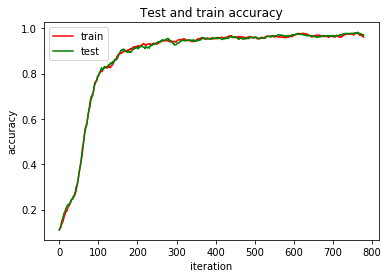

In [16]:
draw_stats([ppl.get_variable('acc_history'), ppl_test.get_variable('test_acc_history')], \
           ['train', 'test'], 'Test and train accuracy')

Average accuracy on test:

In [17]:
np.mean(np.array(ppl_test.get_variable('test_acc_history')[-100:]))

0.97210002